# Data Extracts

In [73]:
import pandas as pd
import pickle
import datetime

## 1. Cases by state (response)

In [23]:
# fetch US data from the NY Times github
covid_us = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")

# transform date to datetime object
covid_us["date"] = pd.to_datetime(covid_us["date"])

covid_us.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [70]:
def impute_missing_dates(df):
    '''
    function that imputes cases and deaths data for missing 
    dates with 0. returned df should have same MIN_DATE and 
    MAX_DATE for all states.
    '''
    # set min values
    MIN_DATE = df["date"].min()
    MIN_CASES = 0
    MIN_DEATHS = 0
    
    # iterate through all states
    imputed_data = []    
    for state in df["state"].unique():
        # build list of missing dates
        # https://stackoverflow.com/questions/7274267/print-all-day-dates-between-two-dates
        sdate = MIN_DATE
        edate = df.loc[df["state"] == state]["date"].min()
        delta = edate - sdate 

        # iterate through all missing dates and impute case and 
        # death data
        for i in range(delta.days):
            day = sdate + datetime.timedelta(days=i)
            imputed_data.append({"date": day,
                                 "state": state,
                                 "fips": df.loc[df["state"]==state].iloc[0]["fips"],
                                 "cases": MIN_CASES,
                                 "deaths": MIN_DEATHS})

    # final cleanup
    new_df = pd.concat([pd.DataFrame(imputed_data), df])
    new_df = new_df.sort_values(by=["state", "date"]).reset_index().drop("index", axis=1)
    
    return new_df
    

In [71]:
# map state abbreviation
states_dict = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [72]:
# clean data by imputing missing dates and mapping abbreviations
covid_us_cleaned = impute_missing_dates(covid_us)
covid_us_cleaned["abbrev"] = covid_us_cleaned["state"].map(states_dict)

covid_us_cleaned.head()

,date,state,fips,cases,deaths,abbrev
0,2020-01-21,Alabama,1,0,0,AL
1,2020-01-22,Alabama,1,0,0,AL
2,2020-01-23,Alabama,1,0,0,AL
3,2020-01-24,Alabama,1,0,0,AL
4,2020-01-25,Alabama,1,0,0,AL


In [78]:
# dump to pickle file
pickle.dump( covid_us_cleaned, open("../data/us_state_cases_deaths.p", "wb" ))

## 2. Google search data

In [79]:
import pytrends
from pytrends.request import TrendReq

# connect 
pyt = TrendReq(hl='en-US', tz=300)

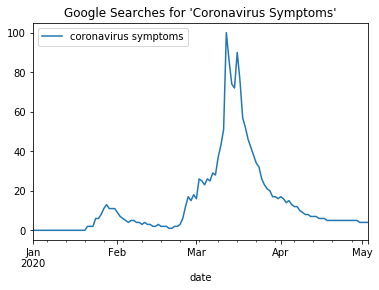

In [80]:
# build query: "coronavirus symptoms" searches starting at 2020
kw_list = ["coronavirus symptoms"]
time_frame = f'''2020-01-01 {datetime.datetime.now().strftime("%Y-%m-%d")}'''
pyt.build_payload(kw_list, cat=0, timeframe=time_frame, geo='US', gprop='')

# interest over time
search_coronavirus = pyt.interest_over_time()
search_coronavirus.plot.line(y="coronavirus symptoms")
plt.title("Google Searches for 'Coronavirus Symptoms'");


In [107]:
kw_list = ["coronavirus symptoms"]
pyt.build_payload(kw_list, cat=0, timeframe="2020-01-01 2020-01-01", geo='US', gprop='')
# pyt.interest_over_time()
pyt.interest_by_region()

,coronavirus symptoms
geoName,
Alabama,0
Alaska,0
Arizona,0
Arkansas,0
California,0
Colorado,0
Connecticut,0
Delaware,0
District of Columbia,0


In [118]:
sdate = datetime.datetime.strptime("2020-01-01", "%Y-%m-%d")
edate = datetime.datetime.strptime("2020-01-03", "%Y-%m-%d")
delta = edate - sdate 

# # iterate through all missing dates and impute case and 
# # death data
# for i in range(delta.days):
#     day = sdate + datetime.timedelta(days=i)
#     s_day = datetime.datetime.strftime(day, "%Y-%m-%d")
#     pyt.build_payload(kw_list, cat=0, timeframe=f"{day} {day}", geo='US-AL', gprop='')

    

2020-01-01
2020-01-02


In [125]:
# method 2: fetch by state
states = list(states_dict.values())
now = datetime.datetime.now().strftime("%Y-%m-%d")

for state in states:
    pyt.build_payload(kw_list, cat=0, timeframe=f"2020-01-1 {now}", geo=f"US-{state}", gprop='')
    interest = pyt.interest_over_time()[["coronavirus symptoms"]]

In [130]:
pyt.build_payload(kw_list, cat=0, timeframe=f"2020-01-1 {now}", geo='US-AL', gprop='')
interest = pyt.interest_over_time()[["coronavirus symptoms"]]
interest

,coronavirus symptoms
date,
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,0
2020-01-05,0
...,...
2020-04-29,5
2020-04-30,3
2020-05-01,2
